# Resolución EDP (problema DIRECTO)

# Ecuación de ondas (unidimensional) 🌊📈

Consideramos el sistema de ecuaciones en derivadas parciales dado por:

\begin{equation}
\begin{cases}
	u_{tt} - c^2 \Delta u = f(x,t), & (x,t) \in \Omega \times T, \\
	u(x,t_0) = g(x), & x \in \Omega, \\
	u_t(x,t_0) = h(x), & x \in \Omega, \\
	u(x_0,t) = \iota(t), & t \in T, \\
	u_x(x_1,t) = \kappa(t), & t \in T.
\end{cases}
\end{equation}

donde $u$ es la solución del sistema, $\Omega$ es el dominio espacial, $T$ es el dominio temporal y $c \in \mathbb{R}^+$, un parámetro relacionado con la velocidad de desplazamiento de la onda en el medio elástico.

Tomamos $g(x) = μcos(2πx)$,  $h(x) = 0$, $\iota(t) = μcos(2πct)$ y $f \equiv 0$ para tener la EDP conocida como **ecuación de ondas unidimensional** (dim $\Omega = 1$).

La solución exacta es conocida e igual a $u(x,t) = \mu cos(2πx)cos(2πct)$ (hallada usando la fórmula de DÁlembert).

A continuación, definimos el código utilizando *TensorFlow*:

In [ ]:
import numpy as np                               # Librería de cálculo numérico.
!pip install deepxde                             # Instalación de la librería previamente.
import deepxde as dde                            # Librería de PINNs.
import tensorflow as tf                          # Librería de redes neuronales.
import matplotlib.pyplot as plt                  # Librería de gráficos.
from matplotlib.animation import FuncAnimation   # Función para gráficas animadas.

from mpl_toolkits.mplot3d import Axes3D          # Función para gráficas 3D
from pandas import DataFrame                     # Función para el agrupamiento de datos en tablas.
from google.colab import data_table              # Función para el agrupamiento de datos en tablas dinámicas.
from IPython import display                      # Función para mostrar gráficos en el propio entorno de trabajo.
from itertools import product                    # Librería de herramientas para bucles.

#print("Version de TensorFlow: ", tf.__version__)       # Comprobamos la versión de TensorFlow
#print("GPU disponible: ", tf.test.is_gpu_available())  # Comprobamos que el programa se halla conectado a una GPU.

### Parámetros:

In [ ]:
# PARÁMETROS Y APLICACIONES DEL PROBLEMA.

# Parámetros:
T = [0, 1]               # Dominio temporal
X = [0, 1]               # Dominio espacial
c = 1                    # Velocidad de la onda en el medio
# c = 1.2
# c = 1.5
# c = 2
mu = 0.8                 # Constante de las condiciones del problema
# mu = 0.6
# mu = 1.1
# mu = 0.2

# Aplicaciones:

# Residuo de la EDP
def residuo_edp(x, u):
# Ayuda de la función
  '''
  Determina el residuo (ERROR) de la predicción dada por la red respecto de la EDP
  considerada.

  INPUTS:
    -> X: (list) Datos de entrada introducidos como una matriz cuyas columnas
          se corresponden con cada una de las coordenadas del dominio
          espaciotemporal del problema. En particular, considera la
          **última coordenada** (última columna en la matriz: x[:, -1]) como la que
          corresponde con la variable temporal.
    -> u: (func) Función incógnita del problema.

  OUTPUTS:
    -> Residuo respecto de la EDP
  '''
  # Cálculo de las derivadas parciales que figuran en la expresión de la EDP
  du_tt = dde.grad.hessian(u, x, i=1, j=1)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)

  return du_tt - (c**2)*du_xx
  # Aplicaciones de las condiciones iniciales
def func_inic_pos(x):    # Posición inicial
  return mu*np.cos(2*np.pi*x[:,0:1])

def func_inic_vel(x):
  return 0.0             # Velocidad inicial

  # Aplicaciones de las condiciones de contorno
def func_dirichlet(x):
  return mu*np.cos(2*np.pi*c*x[:,1:])

def func_neumann(x):
  return 0.0
  # Frontera topológica de la condición de Dirichlet
def boundary_dirichlet(x, on_boundary):
  is_on_boundary_D = (
      on_boundary and np.isclose(x[0], X[0]))
  return is_on_boundary_D
  # Frontera topológica de la condición de Neumann
def boundary_Neumann(x, on_boundary):
  is_on_boundary_N = (
      on_boundary and np.isclose(x[0], X[1]))
  return is_on_boundary_N

  # Frontera topológica de la condición inicial
def boundary_inicial(x, on_initial):
  is_on_boundary = (
      on_initial
      and np.isclose(x[1], T[0])
      and not np.isclose(x[0], X[0])
      and not np.isclose(x[0], X[1]))
  return is_on_boundary

# Solución exacta (Calculada usando Formula de D'Alembert)
def func_exact(x):
  return mu*np.cos(2*np.pi*x[:, 0:1])*np.cos(2*np.pi*c*x[:, 1:])

### Número de puntos de colocación:

In [ ]:
num_coloc_edp = 200              # Para la EDP
num_coloc_boundary = 100         # Para las condiciones de contorno
num_coloc_initial = 25           # Para las condiciones iniciales
number_test = num_coloc_edp

### Dominio del problema:

In [ ]:
# Definición:
# -RECTÁNGULO
geom = dde.geometry.Rectangle(xmin=[X[0], T[0]], xmax=[X[1], T[1]])
# Usamos módulo de geometría del paquete DeepXde


In [ ]:
# Condiciones iniciales y de contorno
bc_izda = dde.DirichletBC(geom, func_dirichlet, boundary_dirichlet)
bc_dcha = dde.NeumannBC(geom, func_neumann, boundary_Neumann)

ic_pos = dde.DirichletBC(geom, func_inic_pos, boundary_inicial)
ic_vel = dde.NeumannBC(geom, func_inic_vel, boundary_inicial)

# Agrupación de todos los datos acerca del problema
data = dde.data.TimePDE(
    geom,
    residuo_edp,
    [bc_izda, bc_dcha, ic_pos, ic_vel],
    num_domain=num_coloc_edp,
    num_boundary=num_coloc_boundary,
    num_test = number_test,
    solution = func_exact)

In [ ]:
# Muestra del conjunto de datos de entrenamiento

#print("El conjunto de datos de entrenamiento es: \n {}".format(data.train_x_all.T))

print("El conjunto de datos de entrenamiento es:")

El conjunto de datos de entrenamiento es:


In [ ]:
# Muestra el conjunto de datos de test

#print("El conjunto de datos de test es: \n {}".format(data.test_x.T))

print("El conjunto de datos de test es:")

El conjunto de datos de test es:


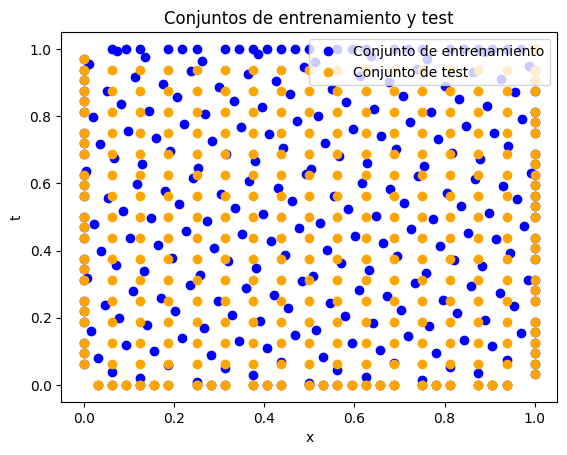

In [ ]:
# Gráfico de los conjuntos de entrenamiento y test
fig, ax = plt.subplots()

ax.plot(data.train_x_all.T[0], data.train_x_all.T[1], "o", color = "blue", label="Conjunto de entrenamiento")
#ax.plot(validating_set.T[0], validating_set.T[1], "ro", label="Conjunto de validación")
ax.plot(data.test_x.T[0], data.test_x.T[1], "o", color = "orange", label="Conjunto de test")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Conjuntos de entrenamiento y test")
ax.legend(loc = "upper right")
plt.show()

### Hiperparámetros:

In [ ]:
capas = [2] + [40] * 5 + [1]       # 2 elementos en la capa de entrada, 3 capas ocultas de 60 neuronas cada una y una quinta con una sola neurona (capa de salida con un único elemento)
func_activacion = "tanh"           # Función de activación "tanh"
learning_rate = 1e-3               # Tasa de aprendizaje
iters = 10000                       # Número de iteraciones del método de optimización
tamanio_lotes = 400                # Tamaño de los "lotes" usados en el entrenamiento
initializer = "Glorot uniform"     # Inicializador de pesos (de acuerdo a una distribución de Glorot)


### Construcción modelo PINN:

In [ ]:
# Construcción de la red neuronal prealimentada (FFNN) que constituye la PINN
net = dde.maps.FNN(capas, func_activacion, initializer)

# Definición del modelo completo
model = dde.Model(data, net)

### Entrenamiento red neuronal:

*   Implementación sobre el modelo de una cierta función de pérdida (MSE)
*   Implementación de algún método de optimización

In [ ]:
# DOBLE ENTRENAMIENTO (reduce errores de entrenamiento y de generalización):
# Primer entrenamiento empleando el método Adam.
model.compile("adam", lr=learning_rate, loss='MSE')#, loss_weights=tasas_fiab)
loss_history, train_state = model.train(iterations=iters, batch_size = tamanio_lotes)

# Segundo entrenamiento empleando el método L-BFGS.
model.compile("L-BFGS", loss='MSE')#, loss_weights=tasas_fib)
loss_history, train_state = model.train(batch_size = tamanio_lotes)

Compiling model...
Building feed-forward neural network...
'build' took 0.278271 s

'compile' took 1.809597 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.78e-02, 3.91e-01, 1.25e-01, 4.27e-01, 2.00e-01]    [3.15e-02, 3.91e-01, 1.25e-01, 4.27e-01, 2.00e-01]    []  
1000      [4.20e-03, 1.12e-02, 3.27e-02, 2.24e-01, 6.97e-03]    [5.07e-03, 1.12e-02, 3.27e-02, 2.24e-01, 6.97e-03]    []  
2000      [7.90e-03, 9.89e-03, 6.01e-02, 1.41e-01, 8.84e-03]    [8.99e-03, 9.89e-03, 6.01e-02, 1.41e-01, 8.84e-03]    []  
3000      [1.28e-02, 2.55e-03, 1.20e-02, 1.97e-02, 4.37e-03]    [1.40e-02, 2.55e-03, 1.20e-02, 1.97e-02, 4.37e-03]    []  
4000      [1.59e-03, 3.50e-04, 7.64e-04, 2.28e-03, 3.87e-04]    [1.95e-03, 3.50e-04, 7.64e-04, 2.28e-03, 3.87e-04]    []  
5000      [8.64e-04, 3.87e-04, 5.21e-04, 7.13e-04, 3.86e-04]    [1.06e-03, 3.87e-04, 5.21e-04, 7.13e-04, 3.86e-04]    []  
60

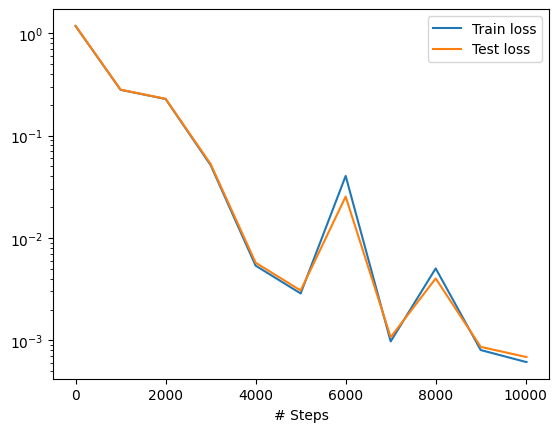

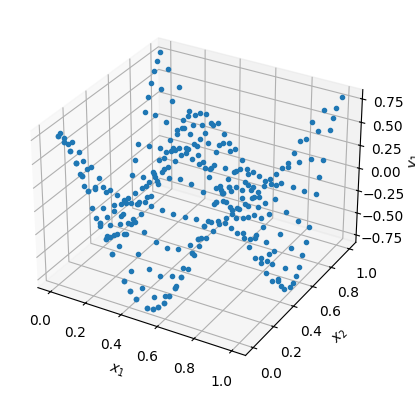

In [ ]:
# Gráficas de los errores de entrenamiento y generalización.
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Predicción sobre la solución del problema:

Predicciones realizadas por la PINN para algunos datos de entrada elegidos uniformemente y su comparación con la solución exacta (conocida)

In [ ]:
# Mallado uniforme sobre el dominio espaciotemporal
n_ptos_x = 100                        # Número de puntos en el eje espacial
n_ptos_t = 100                        # Número de puntos en el eje temporal
xx=np.linspace(X[0],X[1],n_ptos_x)    # Partición del dominio espacial
tt=np.linspace(T[0],T[1],n_ptos_t)    # Partición del dominio temporal

# Extración de los elementos del producto cartesiano que conforma el mallado (ordenado primero según tt y luego según xx).
Xx, Tt = np.meshgrid(xx, tt)

Instante: 0.0 	
[Mín(u_θ), máx(u_θ)] = [-0.7789776921272278, 0.8324085474014282]


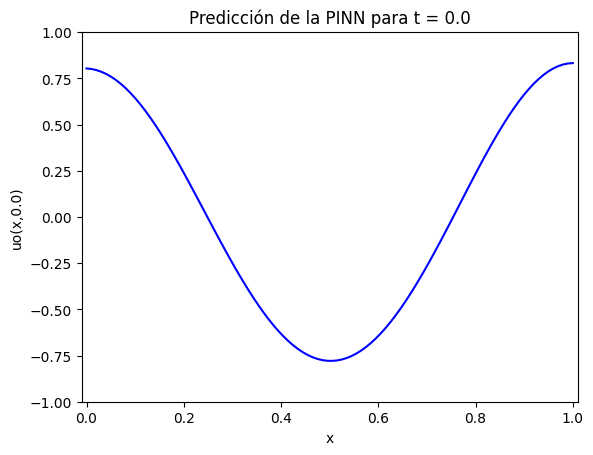

Instante: 0.10101010101010102 	
[Mín(u_θ), máx(u_θ)] = [-0.6361373066902161, 0.6580182313919067]


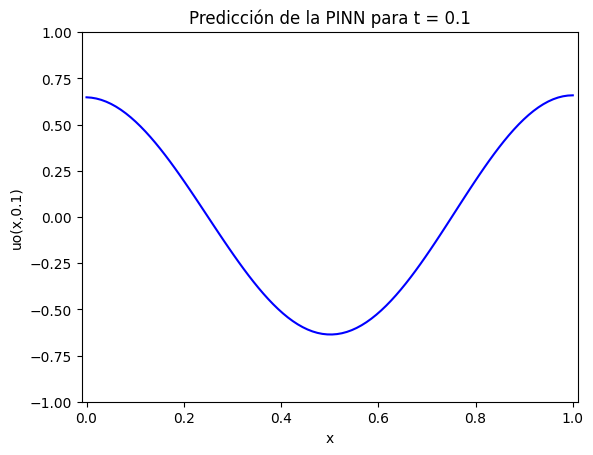

Instante: 0.20202020202020204 	
[Mín(u_θ), máx(u_θ)] = [-0.2491246908903122, 0.24130599200725555]


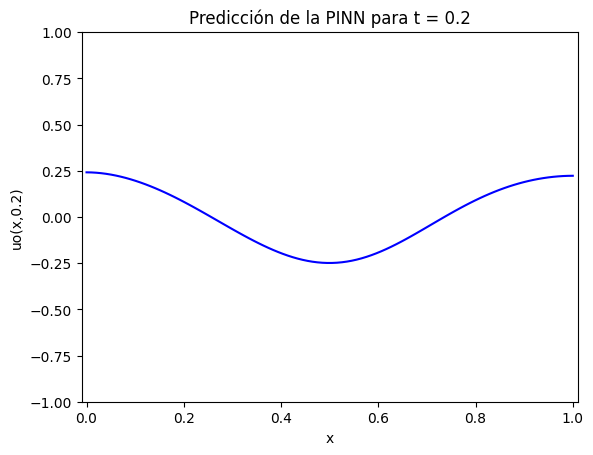

Instante: 0.30303030303030304 	
[Mín(u_θ), máx(u_θ)] = [-0.281298965215683, 0.2502295672893524]


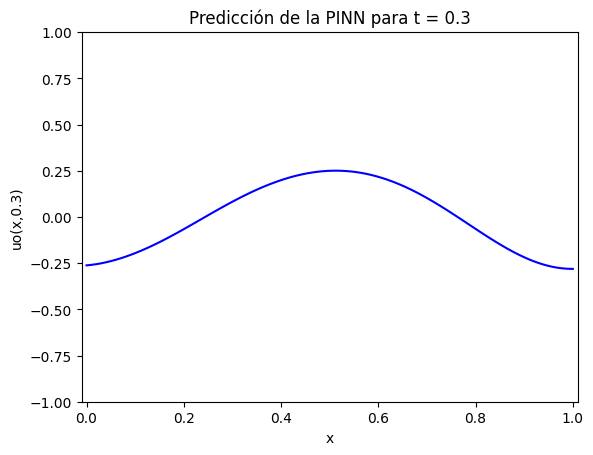

Instante: 0.4040404040404041 	
[Mín(u_θ), máx(u_θ)] = [-0.6647387742996216, 0.6637517213821411]


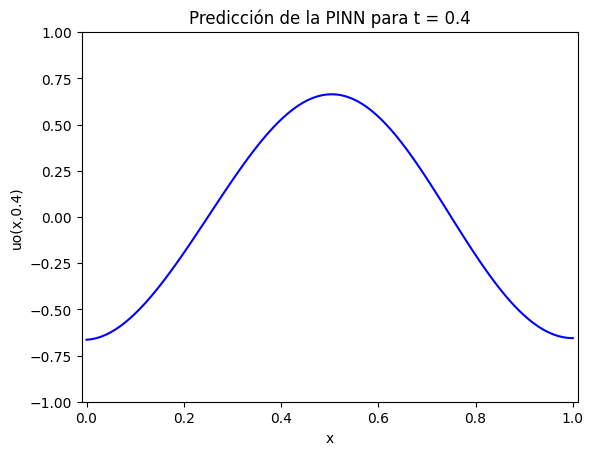

Instante: 0.5050505050505051 	
[Mín(u_θ), máx(u_θ)] = [-0.7997323274612427, 0.8147921562194824]


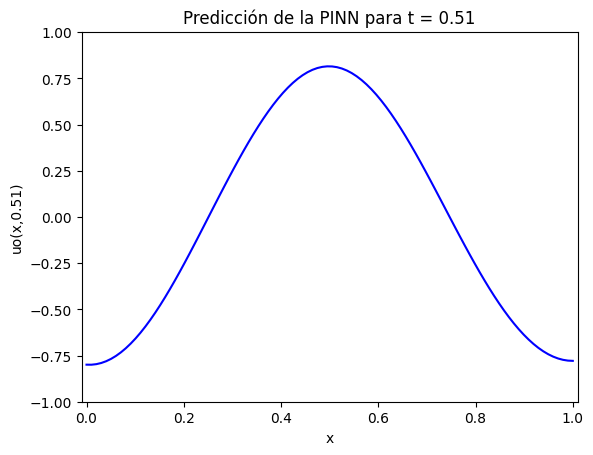

Instante: 0.6060606060606061 	
[Mín(u_θ), máx(u_θ)] = [-0.6225928664207458, 0.639208972454071]


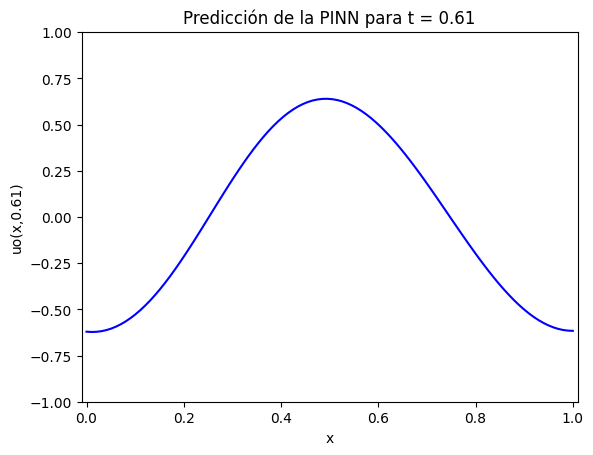

Instante: 0.7070707070707072 	
[Mín(u_θ), máx(u_θ)] = [-0.21914713084697723, 0.2119884192943573]


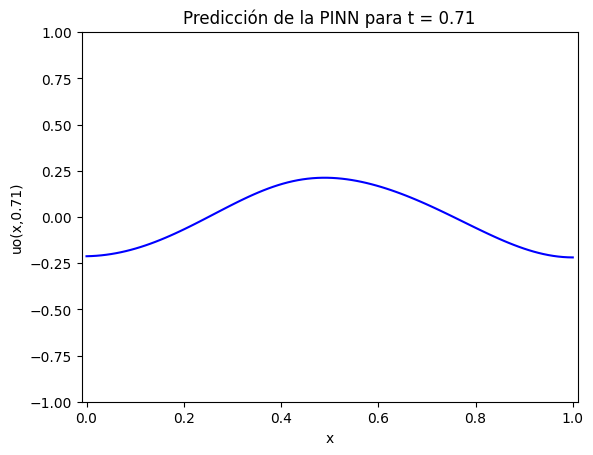

Instante: 0.8080808080808082 	
[Mín(u_θ), máx(u_θ)] = [-0.29852089285850525, 0.2759570777416229]


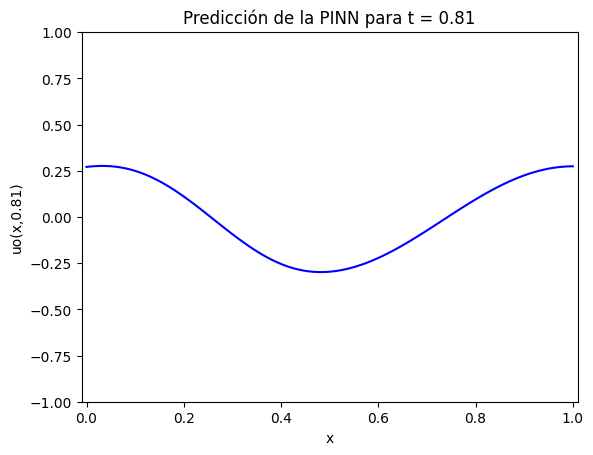

Instante: 0.9090909090909092 	
[Mín(u_θ), máx(u_θ)] = [-0.6866308450698853, 0.668076753616333]


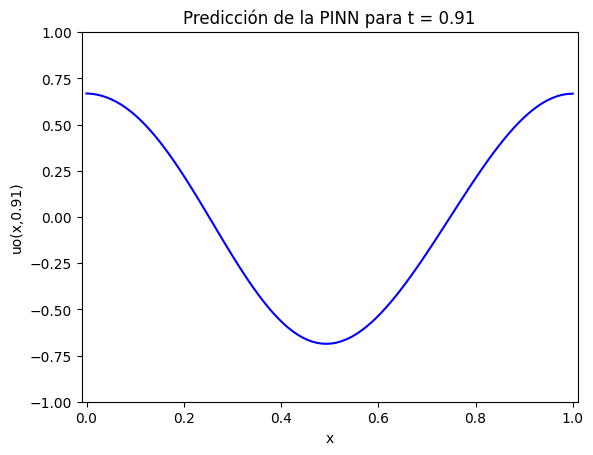

In [ ]:

# Gráfico de la predicción de la PINN por instantes de tiempo (contenidos en el mallado)

num_inst = 10                                                            # Número de instantes de tiempo considerados
t_list = [tt[int(inst*(len(tt)/num_inst))] for inst in range(num_inst)]  # Instantes de tiempo considerados dentro del mallado anterior

for t in t_list:
  print("Instante:", t, "\t")                                            # Impresión en pantalla

  # Restricción del mallado correspondiente al instante considerado
  x_repre, t_repre = np.meshgrid(xx, t)
  XT_list = np.vstack((x_repre.ravel(), t_repre.ravel())).T

  # Predicción realizada por la PINN
  U = model.predict(XT_list).T
  print(f"[Mín(u_θ), máx(u_θ)] = [{min(U[0])}, {max(U[0])}]")             # Impresión en pantalla de los valores mínimo y máximo de la predicción

  # Representación gráfica
  fig, ax = plt.subplots()
  ax.plot(x_repre[0],U[0], color="blue")

  # Instrucciones decorativas del gráfico
  ax.set_title("Predicción de la PINN para t = "+str(round(t,2)))
  ax.set_xlabel("x")
  ax.set_ylabel("uo(x,"+str(round(t,2))+")")
  ax.set_xlim(-0.01,1.01)
  ax.set_ylim(-1.0,1.0)

  plt.show()                                                              # Gráfico

In [ ]:
# Animación de la predicción de la PINN sobre el mallado uniforme

XT_list = []
U = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos

# Representación gráfica
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico
ax.set_title("Predicción de la PINN")
ax.set_xlabel("x")
ax.set_ylabel("u0(x,t)")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-1.0,1.0)

line, = ax.plot(Xx[0],U[0][0], color="blue")
def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(U[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación
display.display(html)
plt.close()

#anim.save('PINNEj1prediccion.mp4', fps=30)     # Almacenamiento de la animación

In [ ]:
# Animación de la solución exacta sobre el mallado uniforme

XT_list = []
sol_exact = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado
  sol_exact.append(func_exact(XT_list[i]).T)   # Solución sobre los puntos

# Representación gráfica
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico
ax.set_title("Solución exacta")
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-1.0,1.0)

line, = ax.plot(Xx[0],sol_exact[0][0], color="green")
def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(sol_exact[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación
display.display(html)
plt.close()

#anim.save('PINNEj1solexacta.mp4', fps=30)     # Almacenamiento de la animación

### Comparación entre la solución exacta y la predicción de la PINN:

In [ ]:
# Animación de la comparación entre la predicción de la PINN y la solución exacta sobre el mallado uniforme.

XT_list = []
U = []
sol_exact = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos
  sol_exact.append(func_exact(XT_list[i]).T)   # Solución sobre los puntos

# Representación gráfica
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico
ax.set_title("Comparación entre la predicción de la PINN y la solución exacta")
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-1.0,1.0)

line1, = ax.plot(Xx[0],U[0][0], color="blue")
line2, = ax.plot(Xx[0],sol_exact[0][0], color="green")
def animate_func(i):
  line1.set_xdata(Xx[i])
  line1.set_ydata(U[i][0])
  line2.set_xdata(Xx[i])
  line2.set_ydata(sol_exact[i][0])
  return line1, line2

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación
display.display(html)
plt.close()

#anim.save('PINNEj1comparacion.mp4', fps=30)     # Almacenamiento de la animación

### Gráfica superficie z=u(x,t) (solución exacta + solución aproximada)

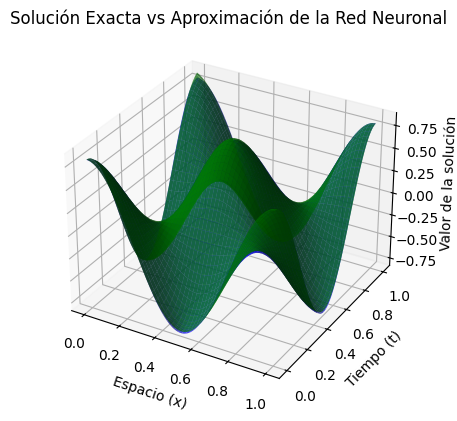

In [ ]:
# Definición del dominio espacio-temporal
x_test = np.linspace(X[0], X[1], 100)                       # Espacio
t_test = np.linspace(T[0], T[1], 100)                       # Tiempo

# Creación del mallado de puntos en el dominio espacio-temporal
x_test, t_test = np.meshgrid(x_test, t_test)                # Malla
inputs = np.vstack((x_test.flatten(), t_test.flatten())).T  # Preparación entradas para la red

# Solución aproximada de la red neuronal
y = model.predict(inputs)                                   # La red devuelve la aproximación de la solución en estos puntos

# Convertir la salida de la red (que está en formato 1D) a una forma 2D
y = y.reshape(x_test.shape)

# Solución exacta (para comparación)
sol_exacta = func_exact(inputs)
sol_exacta = sol_exacta.reshape(x_test.shape)

# Crear la figura 3D para graficar ambas soluciones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar la solución exacta
ax.plot_surface(x_test, t_test, sol_exacta, color='b', alpha=0.7, label="Solución Exacta")

# Graficar la solución aproximada de la red neuronal
ax.plot_surface(x_test, t_test, y, color='g', alpha=0.7, label="Aproximación PINN")

# Etiquetas y título
ax.set_xlabel('Espacio (x)')
ax.set_ylabel('Tiempo (t)')
ax.set_zlabel('Valor de la solución')
ax.set_title("Solución Exacta vs Aproximación de la Red Neuronal")

plt.show()

### Error entre la predicción y la solución exacta:

In [ ]:
# Cálculo del error en norma L^2(Ω)

from scipy.integrate import quad

error = []
for t in tt:
  error.append(quad(lambda x: (model.predict([[x,t]])[0,0] - func_exact(np.array([[x,t]]))[0,0])**2,X[0],X[1]))

error = np.array(error).T

errorL2 = error[0]
error_aprox_integr = error[1]

<ipython-input-52-582021404>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  error.append(quad(lambda x: (model.predict([[x,t]])[0,0] - func_exact(np.array([[x,t]]))[0,0])**2,X[0],X[1]))


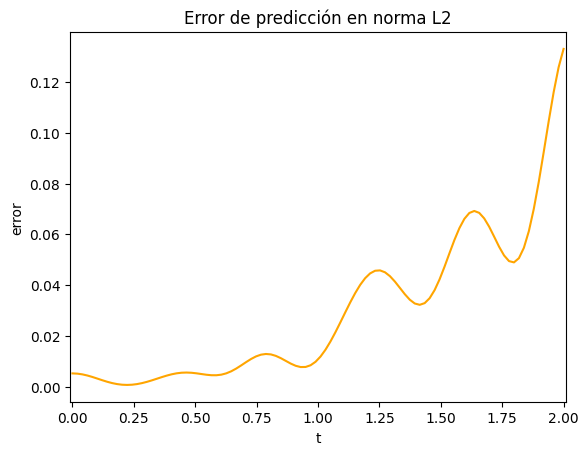

In [ ]:
# Representación gráfica del error en norma L^2(Ω)
fig, ax = plt.subplots()
ax.plot(tt,errorL2, color="orange")

# Instrucciones decorativas del gráfico
ax.set_title("Error de predicción en norma L2")
ax.set_xlabel("t")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)
#ax.set_ylim(-1e-8,7.5e-6)

plt.show()                            # Gráfico

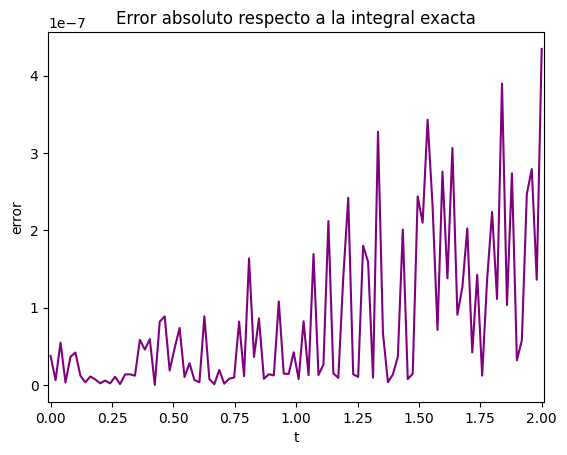

In [ ]:
# Representación gráfica del error de cuadratura
fig, ax = plt.subplots()
ax.plot(tt,error_aprox_integr, color="purple")

# Instrucciones decorativas del gráfico.
ax.set_title("Error absoluto respecto a la integral exacta")
ax.set_xlabel("t")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)
#ax.set_ylim(-1e-8,7.5e-6)

plt.show()                            # Gráfico